In [14]:
import numpy as np
from skimage import measure
from skimage.segmentation import find_boundaries
from skimage.morphology import opening,closing
from skimage.io import imread
from matplotlib import pyplot as plt
import os
from os import listdir
import pandas as pd
from scipy.stats import kde
import seaborn as sns
import copy
from math import exp,log
import pickle
import scipy.ndimage as ndimage
import scipy.interpolate.fitpack as fitpack
from sklearn import manifold,decomposition,random_projection,cluster,metrics,preprocessing,mixture,model_selection
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
import scipy.io as sio

from mpl_toolkits.mplot3d import Axes3D

from nolitsa.dimension import afn
from nolitsa.utils import reconstruct
import glob

from scipy import signal
from scipy.signal import medfilt
from scipy.stats import gaussian_kde

from statsmodels.tsa.ar_model import AR

from tslearn.utils import to_time_series,to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans,KShape,GlobalAlignmentKernelKMeans,silhouette_score
from tslearn.metrics import dtw_path,dtw_subsequence_path,cdist_gak,cdist_dtw,cdist_soft_dtw_normalized
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter,euclidean_barycenter
import sparse
from reactive_traj_classify import find_reaction_start_end,ar1_tipping_time,cross_corr_delay
from sklearn.manifold import MDS,TSNE,SpectralEmbedding


In [15]:
main_path='/home/zoro/Desktop/experiment_data/2019-03-22_a549_tgf4ng_2d/result_bgcorr_norm/'

with open (main_path+'morph_pc_scaler','rb') as fp:
    morph_pc_scaler=pickle.load(fp)

with open (main_path+'vim_pc_scaler','rb') as fp:
    vim_pc_scaler=pickle.load(fp)
    
with open (main_path+'label_spread_4d','rb') as fp:
    ls=pickle.load(fp)
    
# with open (main_path+'scale_gmm','rb') as fp:
#     gmm=pickle.load(fp)
result_path=main_path+'result/'
    
sct_path=main_path+'single_cell_traj/'
#sct_list=sorted(listdir(sct_path))
sct_list=sorted(glob.glob(sct_path+'*long_traj'))

In [16]:
all_reaction_traj=[]
all_reaction_state=[]
cut_reaction_traj=[]

for i in range(len(sct_list)):
    with open (sct_list[i], 'rb') as fp:
        sct = pickle.load(fp)
    if hasattr(sct,'traj_scale_cord') and hasattr(sct,'traj_vimentin_scale_haralick_pca_cord'):
        if sct.traj_scale_cord is not None:
        
            mask=sct.traj_vimentin_feature_values[0]!=0

            traj_t=sct.traj_seri[mask][:,0]
            morph_traj=morph_pc_scaler.transform(sct.traj_scale_cord[mask])
            vim_traj=vim_pc_scaler.transform(sct.traj_vimentin_scale_haralick_pca_cord[mask])
            X0=np.column_stack((morph_traj,vim_traj))
            X=np.column_stack((morph_traj[:,0],vim_traj[:,[0,2,3]]))
            X[:,2]=-X[:,2]

            traj_state=ls.predict(X)
            traj_proba=ls.predict_proba(X)
            reaction_start,reaction_end,enter_M=find_reaction_start_end(traj_state)
            
            if reaction_start<=36 and reaction_end>180:
                
                print(reaction_start,reaction_end)

                reaction_traj=X[reaction_start:reaction_end+1,:]
                reaction_state=traj_state[reaction_start:reaction_end+1]
                all_reaction_traj.append(reaction_traj)
                all_reaction_state.append(reaction_state)
                cut_reaction_traj.append(X[reaction_start:enter_M+1,:])

(8, 258)
(4, 259)
(0, 236)
(0, 283)
(0, 284)
(2, 277)
(0, 284)
(0, 202)
(0, 274)
(1, 205)
(0, 283)
(9, 211)
(1, 240)
(0, 252)
(0, 253)
(2, 274)
(0, 274)
(0, 266)
(0, 283)
(0, 237)
(0, 282)
(0, 283)
(13, 273)
(0, 258)
(0, 283)
(3, 213)
(0, 265)
(0, 255)
(0, 199)
(0, 282)
(0, 192)
(0, 197)
(0, 266)
(1, 280)
(2, 188)
(0, 182)
(1, 255)
(5, 251)
(0, 284)
(3, 208)
(7, 286)
(0, 206)
(0, 281)
(1, 285)
(0, 281)
(0, 286)
(0, 284)
(2, 206)
(0, 281)
(7, 268)
(0, 281)
(0, 283)
(0, 284)
(0, 282)
(0, 201)
(0, 283)
(0, 262)
(1, 286)
(4, 190)
(0, 282)
(0, 282)
(0, 282)
(0, 201)
(0, 229)
(0, 273)
(0, 279)
(0, 187)
(0, 281)
(0, 242)
(0, 211)
(0, 268)
(0, 196)
(0, 280)
(0, 269)
(0, 283)
(0, 233)
(0, 220)
(0, 198)
(0, 285)
(0, 283)
(0, 285)
(0, 224)
(0, 283)
(0, 281)
(2, 283)
(0, 275)
(1, 283)
(6, 281)
(0, 284)
(2, 200)
(0, 286)
(1, 184)
(0, 278)
(0, 280)
(9, 232)
(0, 255)
(0, 285)
(2, 286)
(0, 224)
(0, 215)
(1, 271)
(2, 186)
(0, 285)
(0, 279)
(0, 283)
(0, 201)
(0, 251)
(0, 283)
(0, 276)
(20, 184)
(0, 274)

In [125]:
# M_state_mean=np.mean(np.vstack(all_reaction_traj)[np.concatenate(all_reaction_state,axis=0)==2],axis=0)
# E_state_mean=np.mean(np.vstack(all_reaction_traj)[np.concatenate(all_reaction_state,axis=0)==0],axis=0)
# print(E_state_mean)
# print(M_state_mean)

# for i in range(len(all_reaction_traj)):
#     ind1=np.argmin(np.linalg.norm(all_reaction_traj[i]-E_state_mean,axis=1))
#     ind2=np.argmin(np.linalg.norm(all_reaction_traj[i]-M_state_mean,axis=1))
# #     cut_reaction_traj.append(all_reaction_traj[i][:,:])
#     plt.scatter(all_reaction_traj[i][ind1:ind2+1,0],all_reaction_traj[i][ind1:ind2+1,1],s=0.1)
# plt.show()

In [17]:
X=to_time_series_dataset(cut_reaction_traj)

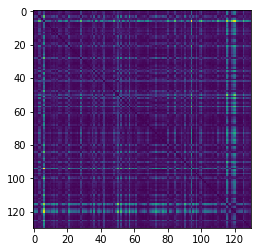

In [18]:
# sct_cdist=cdist_dtw(X)
sct_cdist=cdist_soft_dtw_normalized(X,gamma=5)
np.save(result_path+'sct_soft_cdist.npy',sct_cdist)

plt.imshow(sct_cdist)
plt.show()

In [19]:
# for i in range(len(X)):
#     if Y[i,0]>-20:
#         plt.scatter(X[i][:,0],X[i][:,1],s=0.01,color='b')


# for i in range(len(X)):
#     if Y[i,0]<-20:
#         plt.scatter(X[i][:,0],X[i][:,1],s=0.01,color='r')
# plt.show()

In [20]:
km_dba = TimeSeriesKMeans(n_clusters=2, metric="softdtw",metric_params={"gamma_sdtw":5}, max_iter=10,max_iter_barycenter=10,random_state=0).fit(X)
Y=km_dba.labels_
print(Y,len(Y[Y==0]))


481701.745 --> 160627.973 --> 133963.744 --> 111029.982 --> 92477.110 --> 93257.672 --> 95707.759 --> 95929.988 --> 96212.037 --> 96654.414 --> 
(array([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]), 75)


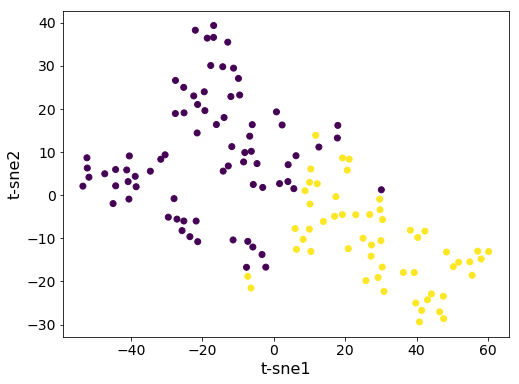

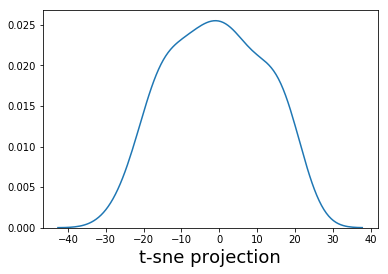

In [21]:
tsne = TSNE(n_components=2, perplexity=6.0, early_exaggeration=10.0, metric='precomputed')
Yp = tsne.fit_transform(sct_cdist)
plt.subplots(figsize=(8,6))

plt.scatter(Yp[:,0],Yp[:,1],c=km_dba.labels_)
plt.xlabel('t-sne1',fontsize=16)
plt.ylabel('t-sne2',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'traj_cluster_tsne.png',dpi=300)

plt.show()

tsne = TSNE(n_components=1, perplexity=6.0,metric='precomputed')
Y1 = tsne.fit_transform(sct_cdist)

sns.kdeplot(Y1[:,0])
plt.xlabel('t-sne projection',fontsize=18)
plt.show()

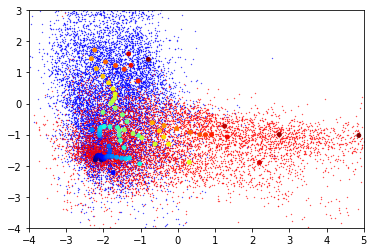

In [22]:
dot_color=np.arange(km_dba.cluster_centers_[0].shape[0])
cm=plt.cm.jet
for i in range(len(X)):
    if Y[i]==0:
        plt.scatter(X[i][:,0],X[i][:,1],s=0.1,color='blue')
# print(km_dba.cluster_centers_.shape)
# plt.axis([-4,4,-4,2])
# plt.show()
dot_color=np.arange(km_dba.cluster_centers_[1].shape[0])
cm=plt.cm.jet
for i in range(len(X)):
    if Y[i]==1:
        plt.scatter(X[i][:,0],X[i][:,1],s=0.1,color='red')
        
plt.scatter(km_dba.cluster_centers_[0,:,0],km_dba.cluster_centers_[0,:,1],s=15,c=dot_color,cmap=cm)

plt.scatter(km_dba.cluster_centers_[1,:,0],km_dba.cluster_centers_[1,:,1],s=15,c=dot_color,cmap=cm)
plt.axis([-4,5,-4,3])

plt.show()

In [23]:
traj_cl1=[]
traj_cl_1=[]
for i in range(len(all_reaction_traj)):
    if Y[i]==0:
        traj_cl1.append(all_reaction_traj[i])
    else:
        traj_cl_1.append(all_reaction_traj[i])
    

75
235450275.512 --> 245181573.226 --> 244984024.397 --> 245123891.436 --> 245119126.021 --> 245122254.509 --> 245121484.528 --> 245121766.138 --> 245121711.268 --> 245121731.940 --> 245121728.460 --> 245121730.262 --> 245121729.938 --> 245121730.144 --> 245121730.089 --> 245121730.118 --> 245121730.118 --> 
165


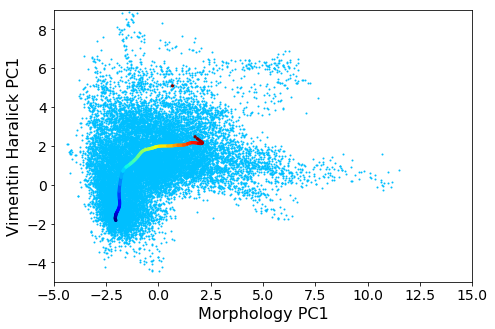

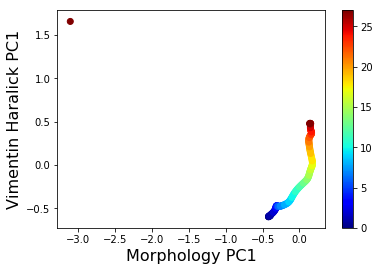

In [24]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
f, ax = plt.subplots(figsize=(7.5,5))
# points = ax.scatter(np.vstack(traj_cl1)[:,0], np.vstack(traj_cl1)[:,1], \
#                     c=np.concatenate(traj_cl1_proba)[:,1], s=1, cmap=cmap)
# f.colorbar(points)
ax.scatter(np.vstack(traj_cl1)[:,0], np.vstack(traj_cl1)[:,1],s=1,color='deepskyblue')
# plt.xlabel('Morphology PC1',fontsize=16)
# plt.ylabel('Vimentin Haralick PC1',fontsize=16)
# plt.axis('equal')




x1=to_time_series_dataset(traj_cl1)
print(len(x1))
#x1_dba=dtw_barycenter_averaging(x1,max_iter=20)
# x1_dba=softdtw_barycenter(x1,gamma=5)
# x1_dba=euclidean_barycenter(x1)
km = TimeSeriesKMeans(n_clusters=1, metric="softdtw",metric_params={"gamma_sdtw":50},verbose=True).fit(x1)
# ks= KShape(n_clusters=1, verbose=True).fit(x1)
x1_dba=km.cluster_centers_[0]

print(x1_dba.shape[0])
dot_c=np.arange(x1_dba.shape[0])/6
cm=plt.cm.get_cmap('jet')
plt.scatter(x1_dba[:,0].ravel(),x1_dba[:,1].ravel(), c=dot_c,cmap=cm,s=5)
plt.xlabel('Morphology PC1',fontsize=16)
plt.ylabel('Vimentin Haralick PC1',fontsize=16)
plt.axis([-5,15,-5,9])
# cbar=plt.colorbar(ticks=np.arange(0,x1_dba.shape[0]//6,12))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'traj_cluster1.png',dpi=300)
plt.show()

plt.scatter(x1_dba[:,2].ravel(),x1_dba[:,3].ravel(), c=dot_c,cmap=cm)
plt.xlabel('Morphology PC1',fontsize=16)
plt.ylabel('Vimentin Haralick PC1',fontsize=16)
# plt.axis([-2,2.5,-2,3])
plt.colorbar()
# plt.savefig(result_path+'ccr_vim_early_mean.tif',dpi=300)
plt.show()
# ax = plt.axes(projection='3d')
# ax.scatter3D(x1_dba[:,0].ravel(),x1_dba[:,1].ravel(),x1_dba[:,2].ravel(),c=dot_c,cmap=cm)
# plt.show()

55
267005251.327 --> 289021211.717 --> 289025349.954 --> 289036117.613 --> 289036551.469 --> 289036632.322 --> 289036652.826 --> 289036658.081 --> 289036660.634 --> 289036661.132 --> 289036661.485 --> 289036661.537 --> 289036661.537 --> 


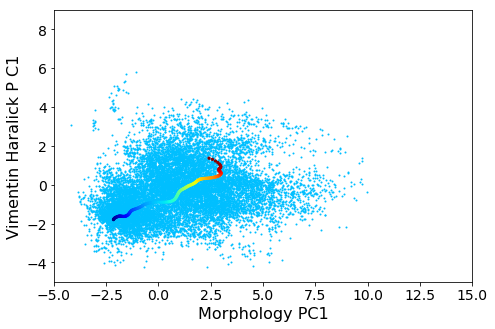

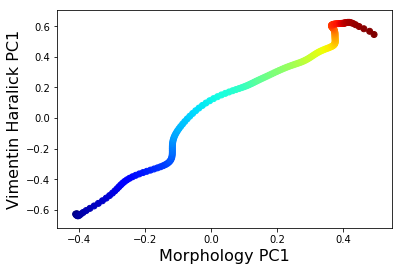

In [25]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
f, ax = plt.subplots(figsize=(7.5,5))
# points = ax.scatter(np.vstack(traj_cl_1)[:,0], np.vstack(traj_cl_1)[:,1], \
#                     c=np.concatenate(traj_cl_1_proba)[:,1], s=1, cmap=cmap)
# f.colorbar(points)
ax.scatter(np.vstack(traj_cl_1)[:,0], np.vstack(traj_cl_1)[:,1],s=1,color='deepskyblue')
plt.xlabel('Morphology PC1',fontsize=16)
plt.ylabel('Vimentin Haralick PC1',fontsize=16)
# plt.axis('equal')


x_1=to_time_series_dataset(traj_cl_1)
print(len(x_1))
# x_1_dba=dtw_barycenter_averaging(x_1,max_iter=20)
# x_1_dba=softdtw_barycenter(x_1,gamma=1,max_iter=100)
# x_1_dba=euclidean_barycenter(x_1)
km = TimeSeriesKMeans(n_clusters=1, metric="softdtw",metric_params={"gamma_sdtw": 50},verbose=True).fit(x_1)
# # ks= KShape(n_clusters=1, verbose=True).fit(x_1)
x_1_dba=km.cluster_centers_[0]


dot_c=np.arange(x_1_dba.shape[0])
cm=plt.cm.get_cmap('jet')
plt.scatter(x_1_dba[:,0].ravel(),x_1_dba[:,1].ravel(), c=dot_c,cmap=cm,s=5)
plt.xlabel('Morphology PC1',fontsize=16)
plt.ylabel('Vimentin Haralick P C1',fontsize=16)
plt.axis([-5,15,-5,9])
# plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'traj_cluster2.png',dpi=300)
plt.show()
plt.scatter(x_1_dba[:,2].ravel(),x_1_dba[:,3].ravel(), c=dot_c,cmap=cm)
plt.xlabel('Morphology PC1',fontsize=16)
plt.ylabel('Vimentin Haralick PC1',fontsize=16)
# plt.axis([-2,2.5,-2,3])
# plt.colorbar()
# plt.savefig(result_path+'ccr_morph_early_mean.png',dpi=300)
plt.show()
# ax = plt.axes(projection='3d')
# ax.scatter3D(x_1_dba[:,0].ravel(),x_1_dba[:,1].ravel(),x_1_dba[:,2].ravel(),c=dot_c,cmap=cm)
# plt.show()

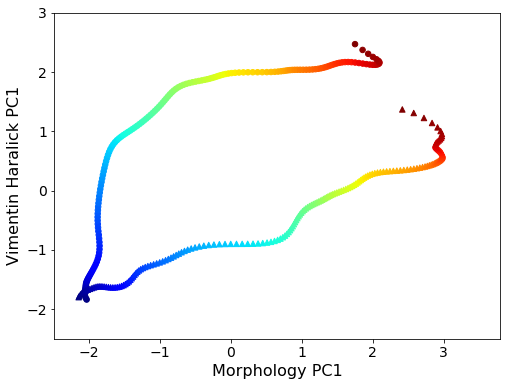

In [26]:
dot_c1=np.arange(x1_dba.shape[0])
dot_c2=np.arange(x_1_dba.shape[0])
cm1=plt.cm.get_cmap('jet')

plt.figure(figsize=(8,6))
plt.scatter(x1_dba[:,0],x1_dba[:,1],c=dot_c1,cmap=cm1,s=30,label='vimentin varies first')
plt.scatter(x_1_dba[:,0],x_1_dba[:,1],c=dot_c2,cmap=cm1,marker='^',s=30,label='morphology varies first')

# cm2=plt.cm.get_cmap('cool')
# plt.scatter(x_1_dba[:,0],x_1_dba[:,1],c=dot_c,cmap=cm1,s=5)
plt.xlabel('Morphology PC1',fontsize=16)
plt.ylabel('Vimentin Haralick PC1',fontsize=16)
# lgnd=plt.legend(['morphology varies first','vimentin varies first'],fontsize=12)
# lgnd=plt.legend(fontsize=14)
# lgnd.legendHandles[0]._sizes = [60]
# lgnd.legendHandles[1]._sizes = [60]
plt.axis([-2.5,3.8,-2.5,3])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'traj_dtw_mean_path.png',dpi=300)
plt.show()

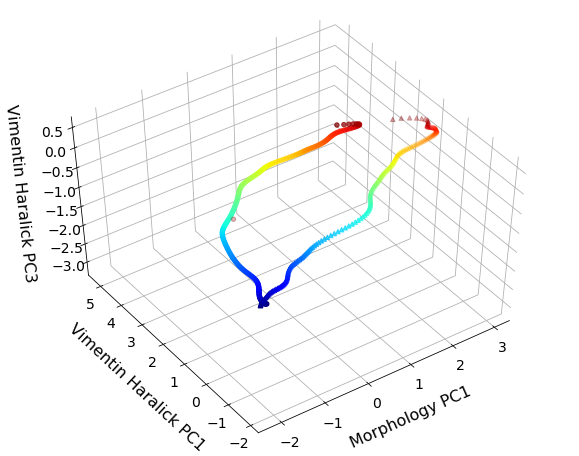

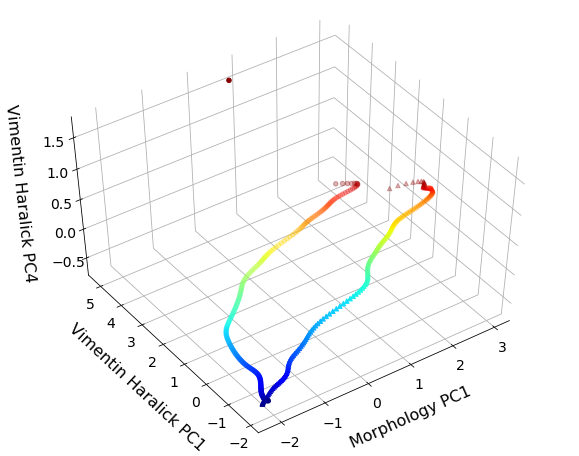

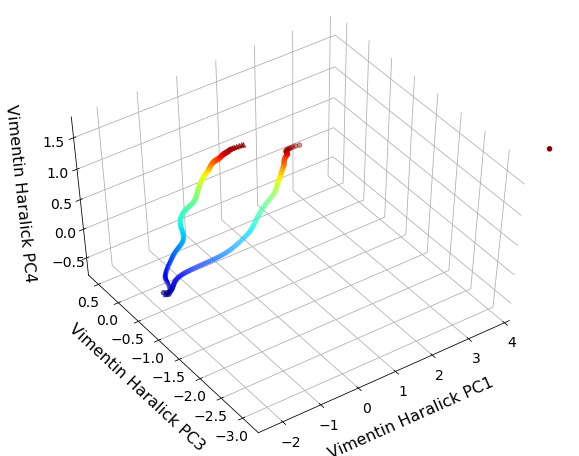

In [27]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(azim=235, elev=50)

dot_c1=np.arange(x_1_dba.shape[0])
dot_c2=np.arange(x1_dba.shape[0])
cm1=plt.cm.get_cmap('jet')
ax.scatter3D(x_1_dba[:,0],x_1_dba[:,1],x_1_dba[:,2],marker='^',s=20,c=dot_c1,cmap=cm1)

ax.scatter3D(x1_dba[:,0],x1_dba[:,1],x1_dba[:,2],marker='o',s=20,c=dot_c2,cmap=cm1)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(14)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlabel('Morphology PC1',fontsize=16,labelpad=15)
ax.set_ylabel('Vimentin Haralick PC1',fontsize=16,labelpad=15)
ax.set_zlabel('Vimentin Haralick PC3',fontsize=16,labelpad=15)
# lgnd=plt.legend(['morphology varies first','vimentin varies first'],fontsize=14)
# lgnd.legendHandles[0]._sizes = [60]
# lgnd.legendHandles[1]._sizes = [60]
# fig.colorbar(s3d,shrink=0.5,aspect=20)
plt.savefig(result_path+'dtw_mean_path_pc113.png',dpi=300)

plt.show()

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(azim=235, elev=50)


ax.scatter3D(x_1_dba[:,0],x_1_dba[:,1],x_1_dba[:,3],marker='^',s=20,c=dot_c1,cmap=cm1)
ax.scatter3D(x1_dba[:,0],x1_dba[:,1],x1_dba[:,3],marker='o',s=20,c=dot_c2,cmap=cm1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(14)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlabel('Morphology PC1',fontsize=16,labelpad=15)
ax.set_ylabel('Vimentin Haralick PC1',fontsize=16,labelpad=15)
ax.set_zlabel('Vimentin Haralick PC4',fontsize=16,labelpad=15)
# lgnd=plt.legend(['morphology varies first','vimentin varies first'],fontsize=14)
# lgnd.legendHandles[0]._sizes = [60]
# lgnd.legendHandles[1]._sizes = [60]
# fig.colorbar(s3d,shrink=0.5,aspect=20)
plt.show()




fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(azim=235, elev=50)

dot_c=np.arange(max(x1_dba.shape[0],x_1_dba.shape[0]))
cm1=plt.cm.get_cmap('jet')
ax.scatter3D(x_1_dba[:,1],x_1_dba[:,2],x_1_dba[:,3],marker='^',s=20,c=dot_c1,cmap=cm1)
ax.scatter3D(x1_dba[:,1],x1_dba[:,2],x1_dba[:,3],marker='o',s=20,c=dot_c2,cmap=cm1)
plt.xlim((-2.5,4))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
for t in ax.zaxis.get_major_ticks(): t.label.set_fontsize(14)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlabel('Vimentin Haralick PC1',fontsize=16,labelpad=15)
ax.set_ylabel('Vimentin Haralick PC3',fontsize=16,labelpad=15)
ax.set_zlabel('Vimentin Haralick PC4',fontsize=16,labelpad=15)
# lgnd=plt.legend(['morphology varies first','vimentin varies first'],fontsize=12)
# lgnd.legendHandles[0]._sizes = [60]
# lgnd.legendHandles[1]._sizes = [60]
# fig.colorbar(s3d,shrink=0.5,aspect=20)
plt.savefig(result_path+'dtw_mean_path_pc134.png',dpi=300)

plt.show()